# Feature Selection Notebook:

This notebook contains the code for preprocessing and feature selection.

We run the `preprocess_and_train` function from `preptrain.py`.

We leverage Bayesian optimization for hyperparameter tuning for methods where that's an option.

We save the selected features to a separate .csv file, `df_selected.csv`, which we use in our models in the `Models.ipynb`.

In [1]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel, RFE, RFECV, mutual_info_regression
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np
import time

import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

from pltcorrheatmap import plot_corr_heatmap
from preptrain import preprocess_and_train
from print_imps import print_importances

In [2]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")

In [3]:
print(df.shape)
print(df_last.shape)

(11282, 53)
(1665, 53)


In [4]:
start_time = time.time()

# Call the function to preprocess the data and perform feature selection
(features_filter, features_wrapper, 
            features_embedded, features_pca, feature_names,
            features_rfecv, features_wrapper_gbm,
            features_embedded_svr,
            X_train, X_test, y_train, y_test) = preprocess_and_train(df, df_last, labels)

end_time = time.time()
execution_time = end_time - start_time
print(f"Feature Selection execution time: {round(execution_time/60, 2)} minutes")

/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 'auto', 'linear'] before, using random point [0.9396283863970801, 'auto', 'rbf']
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 'auto', 'linear'] before, using random point [0.8918826092620564, 'auto', 'linear']
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 'auto', 'linear'] before, using random point [0.6573816561248351, 'auto', 'poly']
  warnings.warn(


Feature Selection execution time: 4.49 minutes


In [5]:
# Print selected features
print("SelectKBest:", features_filter)
print("RF:", features_wrapper)
print("LassoCV:", features_embedded)
print(f"PCA 1: {features_pca[0]}")
print("RFECV:", features_rfecv)
print("GBM:", features_wrapper_gbm)
print("SVR:", features_embedded_svr)

SelectKBest: ['FT', 'FTA', 'PER', 'OWS', 'WS', 'WS/48', 'OBPM', 'BPM', 'VORP', 'Trp Dbl']
RF: ['WS', 'VORP', 'BPM', 'PER', 'OBPM', 'WS/48', 'OWS', 'Rk_Year', 'Rk_Conf', 'Overall']
LassoCV: ['VORP', 'Trp Dbl']
PCA 1: ['FGA', 'FT', 'VORP', 'MP', 'FTA', '2P', 'PER', 'FG', 'PTS', 'WS']
RFECV: ['FG%', '2P', 'FG', 'FGA', '3P', 'MP', '3PA', 'GS', '3P%', 'Age']
GBM: ['WS', 'VORP', 'OBPM', 'Overall', 'BPM', 'WS/48', 'Rk_Conf', 'PTS', 'FG', 'PER']
SVR: ['WS', 'VORP', 'WS/48', 'OWS', 'DWS', 'PER', 'BPM', 'OBPM', 'TOV', 'Rk_Conf']


In [6]:
# Combine selected features from different methods into a single list
combined_features = (features_filter + features_wrapper + features_embedded + 
                     features_pca[0] + features_rfecv + 
                     features_wrapper_gbm + features_embedded_svr)

# Calculate feature importance scores
feature_scores = {}
for feature in combined_features:
    feature_scores[feature] = feature_scores.get(feature, 0) + 1

# Rank features based on importance scores
ranked_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Select top 20 features
top_20_features = [feature for feature, _ in ranked_features[:20]]

# Print the top 20 features
print("Top 20 features:")
for i, (feature, score) in enumerate(ranked_features[:20], start=1):
    print(f"{i}. {feature}: {score}")

Top 20 features:
1. VORP: 6
2. PER: 5
3. WS: 5
4. WS/48: 4
5. OBPM: 4
6. BPM: 4
7. OWS: 3
8. Rk_Conf: 3
9. FG: 3
10. FT: 2
11. FTA: 2
12. Trp Dbl: 2
13. Overall: 2
14. FGA: 2
15. MP: 2
16. 2P: 2
17. PTS: 2
18. Rk_Year: 1
19. FG%: 1
20. 3P: 1


### Out of the top 20 features, 1-9 are clear enough, but we must decide how to handle 10 because several features tie, including FT, FTA, Trp Dbl, Overall, FGA, MP, 2P, and PTS.

#### Let's look at just the features that tie for 10:

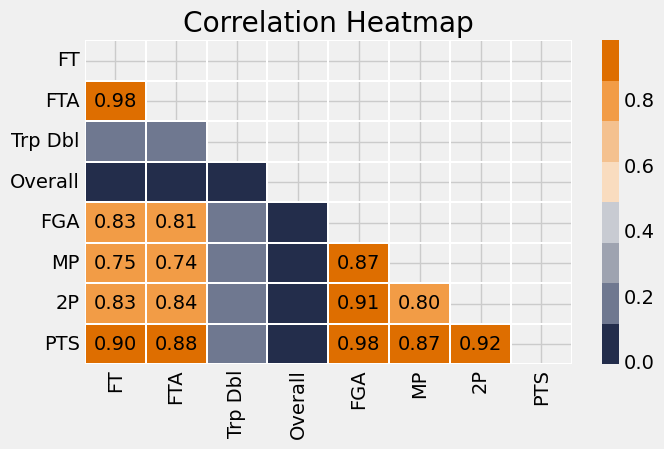

In [17]:
ties = df[['FT', 'FTA', 'Trp Dbl', 'Overall', 'FGA', 'MP', '2P', 'PTS']]

corr_matrix_ties = ties.corr()
plot_corr_heatmap(corr_matrix_ties, ties)

#### Unsurprisingly, the features related to points are highly correlated:
- FTA (Free Throw Attempts)
- FT (Free Throws)
- FGA (Fiels Goal Attempts)
- 2P (Two-pointers)
- PTS (Points)

#### Let's fit a basic RF and see what the feature importances are for these features (this is likey not the best approach given that each of these likely interacts with features 1-9, but it's a start):

In [18]:
ties = ties.drop(columns=['Trp Dbl', 'Overall', 'MP'])

In [19]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(ties, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

In [20]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],    # No. of trees in the forest
    'max_features': ['log2', 'sqrt'],   # No. of features to consider at every split
    'max_depth': [None, 10, 20],        # Max depth of the trees
    'min_samples_split': [2, 5, 10],    # Min no. of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Min no. of samples required to be at a leaf node
    'bootstrap': [True, False]          # Method to select samples for training each tree
}

# Initialize RandomForest
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=50, 
                         scoring='r2', 
                         cv=5,
                         n_points=9,
                         random_state=28, 
                         n_jobs=56)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best model
best_rf = bayes_rf.best_estimator_

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Model execution time: 0.81 minutes


In [21]:
feature_names = ties.columns

print_importances(feature_names, best_rf)

Feature Importances:
PTS : 0.3814175646296654
FTA : 0.17841480404724755
2P : 0.16411890403493667
FGA : 0.14708795668548347
FT : 0.12896077060266692


### We see that PTS is more important, at least to this RF, so let's drop the the others.

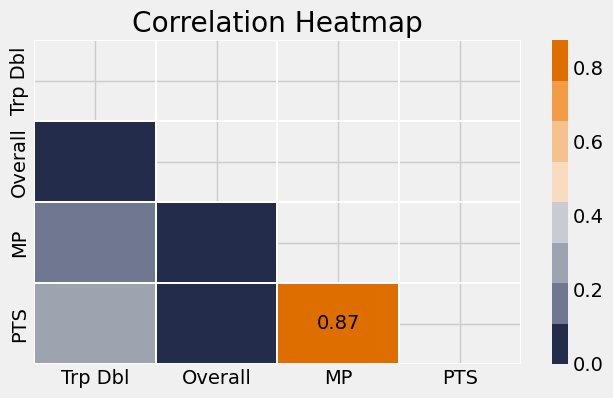

In [22]:
ties2 = df[['Trp Dbl', 'Overall', 'MP', 'PTS']]

corr_matrix_ties = ties2.corr()
plot_corr_heatmap(corr_matrix_ties, ties2)

#### This is slightly better in terms of multicollinearity, but still some issues. Let's repeat the RF to see which of these has highest importance:

In [23]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(ties2, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

In [24]:
start_time = time.time()

# Initialize XGBRegressor
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=50, 
                         scoring='r2', 
                         cv=5,
                         n_points=9,
                         random_state=28, 
                         n_jobs=56)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best model
best_rf = bayes_rf.best_estimator_

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Model execution time: 0.78 minutes


In [25]:
feature_names = ties2.columns

print_importances(feature_names, best_rf)

Feature Importances:
PTS : 0.4162480228305681
Overall : 0.3646114944115929
Trp Dbl : 0.1268856612826291
MP : 0.0922548214752099


#### This is interesting, as they're PTS and Overall are very close, so let's drop Trp Dbl and MP and repeat:

In [26]:
ties3 = df[['Overall', 'PTS']]

In [27]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(ties3, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

In [28]:
start_time = time.time()

# Initialize XGBRegressor
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=50, 
                         scoring='r2', 
                         cv=5,
                         n_points=9,
                         random_state=28, 
                         n_jobs=56)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best model
best_rf = bayes_rf.best_estimator_

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Model execution time: 0.61 minutes


In [29]:
feature_names = ties3.columns

print_importances(feature_names, best_rf)

Feature Importances:
PTS : 0.745633656607004
Overall : 0.254366343392996


#### PTS is more important (according to this RF), but PTS is highly correlated with feature 9 (FG), so let's use Overall.

In [34]:
selected_features = ['VORP', 'PER', 'WS', 'WS/48', 'OBPM', 'BPM', 'OWS', 'Rk_Conf', 'FG', 'Overall']

## Selected Features:

- VORP = Value Over Replacement Player -- $[BPM - (-2.0)]*$(% of possessions played)$ * \frac{team games}{82}$.

- PER = Player Efficiency Rating (see <a href="https://www.basketball-reference.com/about/per.html">Calculating PER</a> for the formula).

- WS = Win Shares (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for information about how this feature is calculated).

- WS/48 = Win Shares Per 48 Minutes (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for information about how this feature is calculated).

- OBPM = Offensive Box Plus/Minus. This is a box score that compares a player's offensive impact to the league average (see <a href="https://www.basketball-reference.com/about/bpm2.html">About Box/Plus Minus)</a> for details on calculating the offensive box score).

- BPM = Box Plus/Minus (see <a href="https://www.basketball-reference.com/about/bpm2.html">About Box Plus/Minus (BPM)</a> for the formula).

- OWS = Offensive Win Shares (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for more information on how this is calculated.
   
- Overall = The ratio of team wins and losses in which a player plays; high value indicates many wins.

- FG = Field Goals (includes 2-point field goals and 3-point field goals).

- Rk_Conf = Team conference ranking.

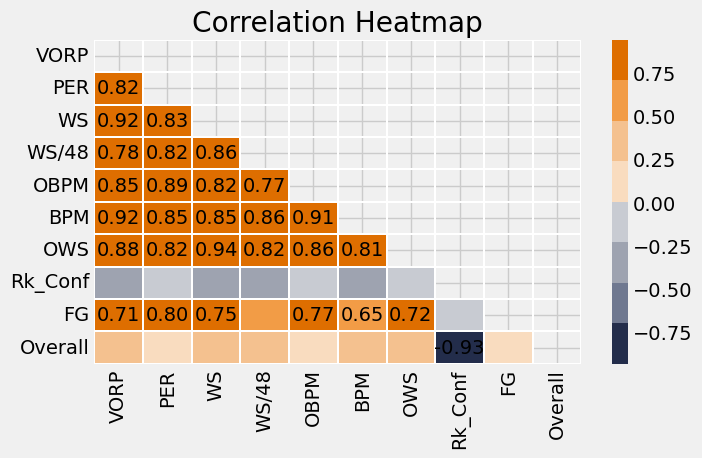

In [35]:
# Select only the columns corresponding to the top 10 features
df_check_selected = df[selected_features]
corr_matrix = df_check_selected.corr()

plot_corr_heatmap(corr_matrix, selected_features)

### These are still highly correlated, but let's proceed to modeling and index buidling for now.

In [36]:
df_selected = df[selected_features]
df_selected.to_csv('df_selected.csv', index=False)